### Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Bidirectional,Dense,SpatialDropout1D,Embedding,GRU
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

### Loading the data from csv file on which preprocessing is done already

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/complete_preporcessing_drug_review.csv')
data.drop(['Unnamed: 0'],axis=1,inplace=True)

In [ ]:
data.review=data.review.astype(str)

In [ ]:
data.head()

,review,sentiment
0,side effect take combination bystolic milligra...,2
1,son halfway fourth week intuniv become concern...,1
2,use take another oral contraceptive pill cycle...,0
3,first time use form birth control glad go patc...,1
4,suboxone completely turn life around feel heal...,2


In [ ]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(data.review)

### Vocabulary size

In [ ]:
vocabulary_size=len(tokenizer.word_index)+1

In [ ]:
vocabulary_size

42811

### converting the textual information into the one-hot or numeric values

In [ ]:
seq=tokenizer.texts_to_sequences(data.review)

In [ ]:
num_tokens=[len(sentence)for sentence in seq]
num_tokens=np.array(num_tokens)

#### maximum review length is

In [ ]:
max(num_tokens)

944

#### we will take the avg length of sentences in which most of the reviews fall 95% of data lies in it as per mathematical formula

In [ ]:
max_tokens=np.mean(num_tokens)+2*np.std(num_tokens)
max_tokens

84.17042362086754

In [ ]:
max_tokens=85

### now calculating the %age of data that lies within this when length is kept 85

In [ ]:
np.sum(num_tokens<max_tokens)/len(num_tokens) ##99% data lies within it

0.9956245379260961

#### Note: in research paper the researcher has taken the length of sentences greater than 85 , i think 200

In [ ]:
pad_seq=pad_sequences(seq,maxlen=max_tokens,padding='post')

In [ ]:
pad_seq

array([[  12,   11,    1, ...,    0,    0,    0],
       [ 452, 2624, 1289, ...,    0,    0,    0],
       [  23,    1,  158, ...,    0,    0,    0],
       ...,
       [3185,    6,  108, ...,    0,    0,    0],
       [  78, 1557,   82, ...,    0,    0,    0],
       [   8,    0,    0, ...,    0,    0,    0]], dtype=int32)

### Splitting the data into training and test set

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(pad_seq,data.sentiment,test_size=0.25,random_state=42)

In [ ]:
x_train.shape

(161297, 85)

In [ ]:
x_test.shape

(53766, 85)

#### Loading the pretrained FastText model

In [ ]:
from gensim.models import FastText

In [ ]:
modelf=FastText.load('/content/drive/MyDrive/Colab Notebooks/Fasttext_model2')

### Generating word embeddings with FASTTEXT

In [ ]:
embedding_matrix=np.zeros((vocabulary_size,100))
for word,i in tokenizer.word_index.items():
  if word in modelf.wv:
    embedding_matrix[i]=modelf.wv[word]


In [ ]:
modelf.wv['birth']

array([-0.05843591, -0.34096628, -0.91325855, -0.44902545,  0.06130463,
       -0.429203  ,  0.58045423,  0.05346946, -0.13164623, -0.5473678 ,
       -0.3240666 ,  0.270965  ,  0.26555505, -0.27948517,  0.2601419 ,
       -0.2623356 , -0.1392521 ,  0.21500042, -0.48749638,  0.09647668,
        0.7220927 ,  0.32468572,  0.05849307, -0.52573866,  0.06253142,
       -0.03097827,  0.0120508 , -0.23107259,  0.2393989 , -0.26035473,
        0.20316839,  0.3148518 ,  0.43808916, -0.21598192,  0.1593785 ,
        0.6419307 , -0.27310532,  0.12018342, -0.6400227 ,  0.1284779 ,
        0.5414073 ,  0.12494288,  0.3508112 , -0.37819782, -0.07378837,
        0.21322623, -0.0197391 ,  0.2560009 ,  0.26659703, -0.16103306,
        0.30423552,  0.01076972, -0.06244149,  0.5317932 , -0.36071107,
        0.13927753, -0.18428026,  0.2847531 ,  0.0118041 ,  0.4975654 ,
       -0.02323597,  0.0077946 ,  0.11051185,  0.67663443,  0.41309294,
       -0.17136033, -0.00404761,  0.1232084 , -0.14446501,  0.19

## LSTM without balancing with FastText

In [ ]:
model1=Sequential()
model1.add(Embedding(input_dim=vocabulary_size,output_dim=100,input_length=max_tokens,weights=[embedding_matrix],trainable=False))
model1.add(SpatialDropout1D(0.1))
model1.add(LSTM(units=200,activation='tanh'))
#output layer
model1.add(Dense(3,activation='softmax'))
optimizer=Adam(lr=1e-3)
model1.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 85, 100)           4281100   
                                                                 
 spatial_dropout1d_3 (Spati  (None, 85, 100)           0         
 alDropout1D)                                                    
                                                                 
 lstm_5 (LSTM)               (None, 200)               240800    
                                                                 
 dense_5 (Dense)             (None, 3)                 603       
                                                                 
Total params: 4522503 (17.25 MB)
Trainable params: 241403 (942.98 KB)
Non-trainable params: 4281100 (16.33 MB)
_________________________________________________________________


In [ ]:
history=model1.fit(x_train,y_train,epochs=60,verbose=1,validation_data=(x_test,y_test),batch_size=200)

Epoch 1/60
807/807 [==============================] - 16s 18ms/step - loss: 0.8933 - accuracy: 0.6079 - val_loss: 0.8304 - val_accuracy: 0.6438
Epoch 2/60
807/807 [==============================] - 13s 17ms/step - loss: 0.8130 - accuracy: 0.6463 - val_loss: 0.7742 - val_accuracy: 0.6668
Epoch 3/60
807/807 [==============================] - 14s 18ms/step - loss: 0.7703 - accuracy: 0.6659 - val_loss: 0.7407 - val_accuracy: 0.6774
Epoch 4/60
807/807 [==============================] - 14s 17ms/step - loss: 0.7434 - accuracy: 0.6764 - val_loss: 0.7560 - val_accuracy: 0.6751
Epoch 5/60
807/807 [==============================] - 14s 17ms/step - loss: 0.7210 - accuracy: 0.6886 - val_loss: 0.7003 - val_accuracy: 0.6963
Epoch 6/60
807/807 [==============================] - 14s 17ms/step - loss: 0.7013 - accuracy: 0.6974 - val_loss: 0.6917 - val_accuracy: 0.7008
Epoch 7/60
807/807 [==============================] - 14s 17ms/step - loss: 0.6839 - accuracy: 0.7039 - val_loss: 0.6779 - val_accuracy:

## Results

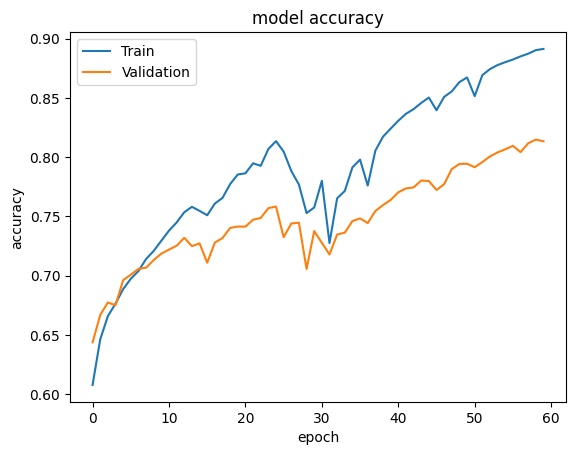

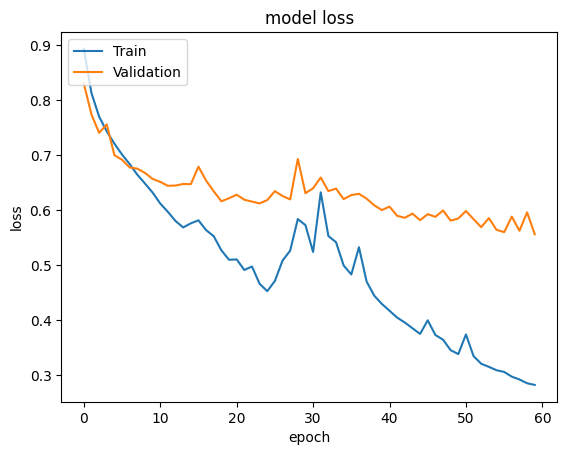

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
loss,accuracy=model1.evaluate(x_test,y_test)

1681/1681 [==============================] - 7s 4ms/step - loss: 0.5563 - accuracy: 0.8134


In [ ]:
print(f"Accuracy:{accuracy}\n Loss:{loss}")

Accuracy:0.8133764863014221
 Loss:0.5563015937805176


In [ ]:
y_pred=model1.predict(x_test)

1681/1681 [==============================] - 5s 3ms/step


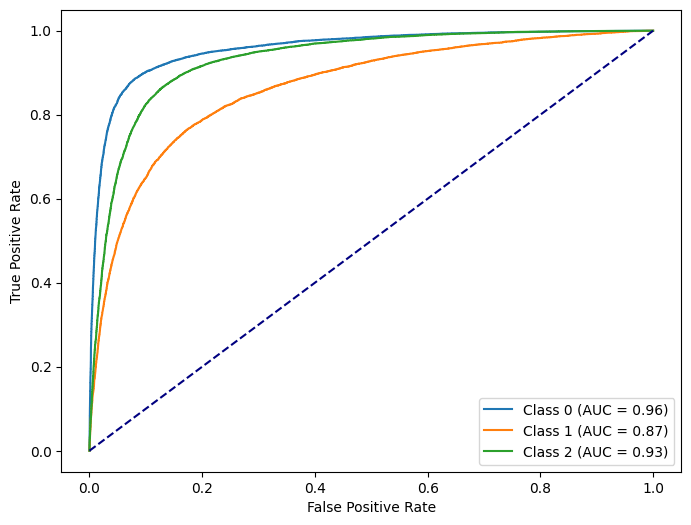

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the true labels (y_test) for each class
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = 3
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class and the diagonal line
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line representing random guessing
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [ ]:
y_pred=np.argmax(y_pred,axis=1)

In [ ]:
# Generate the classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.86      0.86     16099
           1       0.65      0.65      0.65     11697
           2       0.86      0.86      0.86     25970

    accuracy                           0.81     53766
   macro avg       0.79      0.79      0.79     53766
weighted avg       0.81      0.81      0.81     53766



In [ ]:
cm=confusion_matrix(y_test,y_pred)
print(cm)

[[13798  1458   843]
 [ 1409  7562  2726]
 [  902  2696 22372]]


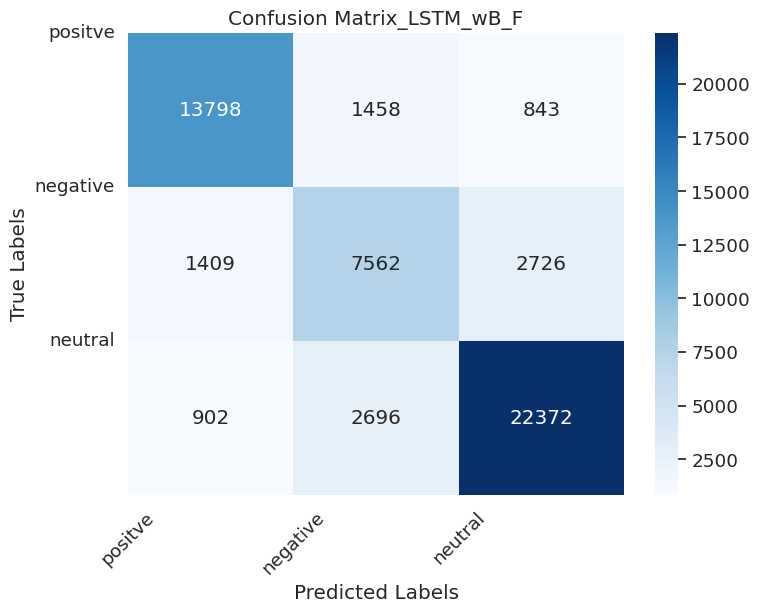

In [ ]:
class_names=['positve','negative','neutral']

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font scale for better readability
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

# Customize labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix_LSTM_wB_F')
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.yticks(ticks=range(len(class_names)), labels=class_names, rotation=0)

plt.show()

## Bi_LSTM without Balancing and Fasttext

In [ ]:
model=Sequential()
model.add(Embedding(input_dim=vocabulary_size,output_dim=100,input_length=max_tokens,weights=[embedding_matrix],trainable=False))
model.add(SpatialDropout1D(0.1))
model.add(Bidirectional((LSTM(units=200,activation='tanh'))))
#output layer
model.add(Dense(3,activation='softmax'))
optimizer=Adam(lr=1e-3)
model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 85, 100)           4281100   
                                                                 
 spatial_dropout1d_9 (Spati  (None, 85, 100)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_3 (Bidirecti  (None, 400)               481600    
 onal)                                                           
                                                                 
 dense_9 (Dense)             (None, 3)                 1203      
                                                                 
Total params: 4763903 (18.17 MB)
Trainable params: 482803 (1.84 MB)
Non-trainable params: 4281100 (16.33 MB)
_________________________________________________________________


In [ ]:
history=model.fit(x_train,y_train,epochs=60,verbose=1,validation_data=(x_test,y_test),batch_size=200)

Epoch 1/60
807/807 [==============================] - 27s 30ms/step - loss: 0.8616 - accuracy: 0.6181 - val_loss: 0.7818 - val_accuracy: 0.6561
Epoch 2/60
807/807 [==============================] - 24s 30ms/step - loss: 0.7767 - accuracy: 0.6589 - val_loss: 0.7459 - val_accuracy: 0.6728
Epoch 3/60
807/807 [==============================] - 24s 29ms/step - loss: 0.7410 - accuracy: 0.6773 - val_loss: 0.7152 - val_accuracy: 0.6883
Epoch 4/60
807/807 [==============================] - 26s 33ms/step - loss: 0.7136 - accuracy: 0.6908 - val_loss: 0.7020 - val_accuracy: 0.6955
Epoch 5/60
807/807 [==============================] - 24s 30ms/step - loss: 0.6896 - accuracy: 0.7023 - val_loss: 0.6914 - val_accuracy: 0.7006
Epoch 6/60
807/807 [==============================] - 27s 33ms/step - loss: 0.6689 - accuracy: 0.7111 - val_loss: 0.6817 - val_accuracy: 0.7030
Epoch 7/60
807/807 [==============================] - 27s 33ms/step - loss: 0.6446 - accuracy: 0.7227 - val_loss: 0.6660 - val_accuracy:

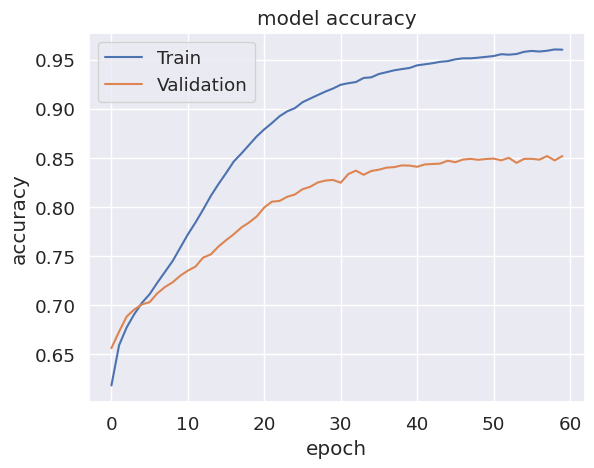

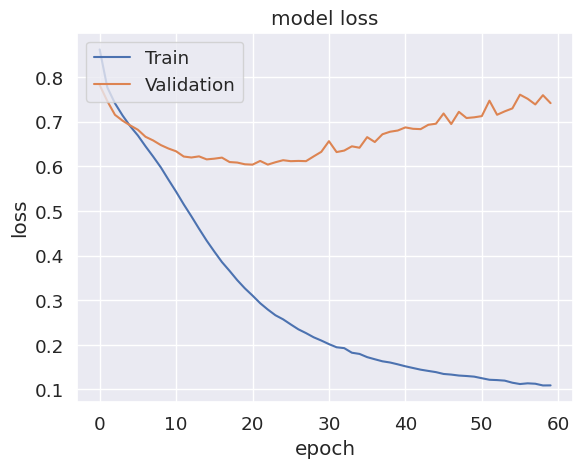

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
loss,accuracy=model.evaluate(x_test,y_test)

1681/1681 [==============================] - 8s 5ms/step - loss: 0.5563 - accuracy: 0.8134


In [ ]:
print(f"Accuracy:{accuracy}\n Loss:{loss}")

Accuracy:0.8133764863014221
 Loss:0.5563015937805176


In [ ]:
y_pred=model.predict(x_test)

1681/1681 [==============================] - 9s 5ms/step


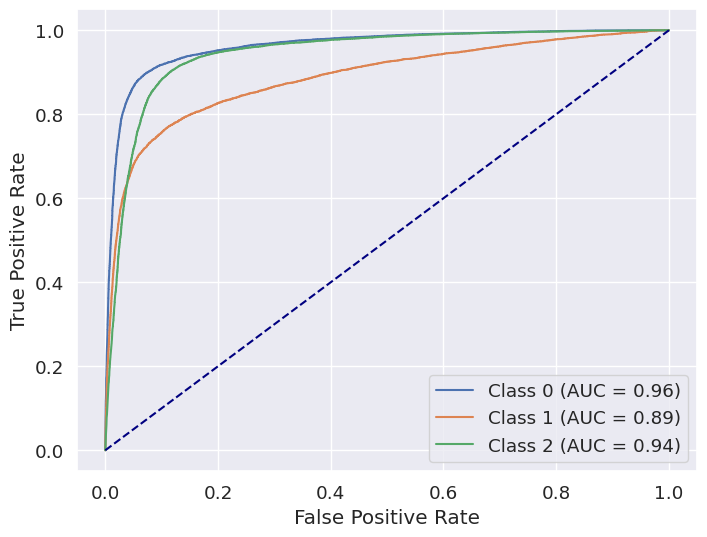

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the true labels (y_test) for each class
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = 3
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class and the diagonal line
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line representing random guessing
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [ ]:
y_pred=np.argmax(y_pred,axis=1)

In [ ]:
# Generate the classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.87      0.87     16099
           1       0.76      0.71      0.73     11697
           2       0.88      0.91      0.89     25970

    accuracy                           0.85     53766
   macro avg       0.84      0.83      0.83     53766
weighted avg       0.85      0.85      0.85     53766



In [ ]:
cm=confusion_matrix(y_test,y_pred)
print(cm)

[[14006  1016  1077]
 [ 1159  8275  2263]
 [  819  1633 23518]]


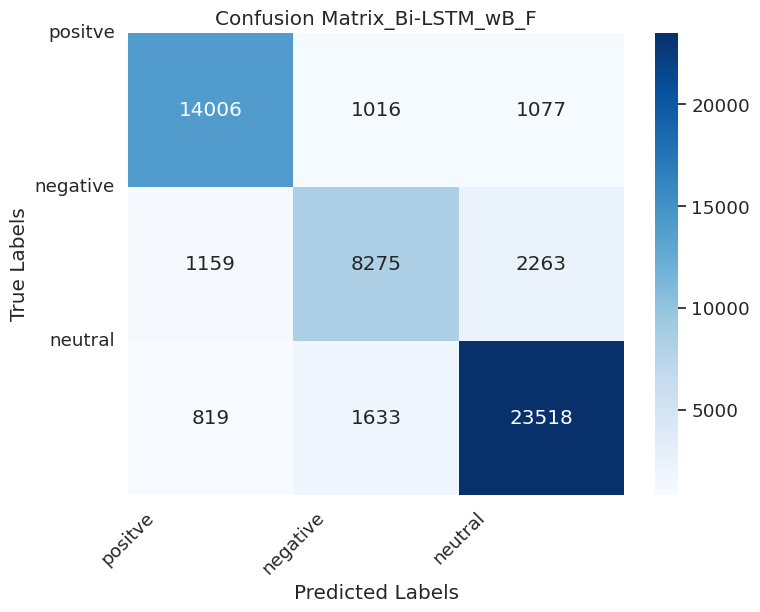

In [ ]:
class_names=['positve','negative','neutral']

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font scale for better readability
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

# Customize labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix_Bi-LSTM_wB_F')
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.yticks(ticks=range(len(class_names)), labels=class_names, rotation=0)

plt.show()

### LSTM+GRU withou balancing and Fasttext

In [ ]:
modell=Sequential()
modell.add(Embedding(input_dim=vocabulary_size,output_dim=100,input_length=max_tokens,weights=[embedding_matrix],trainable=False))
modell.add(SpatialDropout1D(0.1))
modell.add(LSTM(units=200,activation='tanh',return_sequences=True))
modell.add(GRU(units=200,activation='tanh'))
modell.add(Dense(3,activation='softmax'))
optimizer=Adam(lr=1e-3)
modell.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
modell.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 85, 100)           4281100   
                                                                 
 spatial_dropout1d_2 (Spati  (None, 85, 100)           0         
 alDropout1D)                                                    
                                                                 
 lstm_2 (LSTM)               (None, 85, 200)           240800    
                                                                 
 gru_2 (GRU)                 (None, 200)               241200    
                                                                 
 dense_2 (Dense)             (None, 3)                 603       
                                                                 
Total params: 4763703 (18.17 MB)
Trainable params: 482603 (1.84 MB)
Non-trainable params: 4281100 (16.33 MB)
___________

In [ ]:
history=modell.fit(x_train,y_train,epochs=60,verbose=1,validation_data=(x_test,y_test),batch_size=200)

Epoch 1/60
807/807 [==============================] - 30s 33ms/step - loss: 0.8841 - accuracy: 0.6107 - val_loss: 0.7914 - val_accuracy: 0.6543
Epoch 2/60
807/807 [==============================] - 29s 36ms/step - loss: 0.7884 - accuracy: 0.6546 - val_loss: 0.7408 - val_accuracy: 0.6784
Epoch 3/60
807/807 [==============================] - 29s 36ms/step - loss: 0.7423 - accuracy: 0.6767 - val_loss: 0.7146 - val_accuracy: 0.6889
Epoch 4/60
807/807 [==============================] - 29s 36ms/step - loss: 0.7116 - accuracy: 0.6902 - val_loss: 0.6964 - val_accuracy: 0.6979
Epoch 5/60
807/807 [==============================] - 28s 35ms/step - loss: 0.6872 - accuracy: 0.7035 - val_loss: 0.6807 - val_accuracy: 0.7079
Epoch 6/60
807/807 [==============================] - 27s 34ms/step - loss: 0.6651 - accuracy: 0.7138 - val_loss: 0.6694 - val_accuracy: 0.7109
Epoch 7/60
807/807 [==============================] - 30s 37ms/step - loss: 0.6404 - accuracy: 0.7249 - val_loss: 0.6670 - val_accuracy:

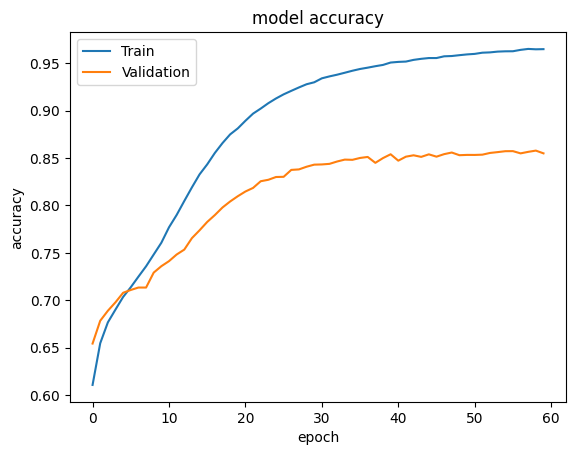

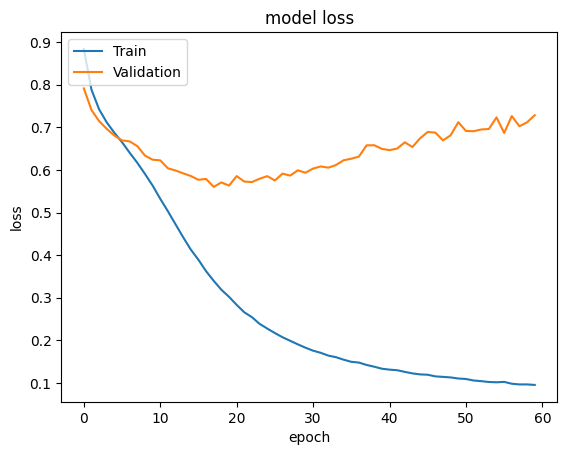

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
loss,accuracy=modell.evaluate(x_test,y_test)
print(f"Accuracy:{accuracy}\n Loss:{loss}")


1681/1681 [==============================] - 10s 6ms/step - loss: 0.7285 - accuracy: 0.8550
Accuracy:0.8550199270248413
 Loss:0.7285253405570984


In [ ]:
y_pred=modell.predict(x_test)

1681/1681 [==============================] - 8s 4ms/step


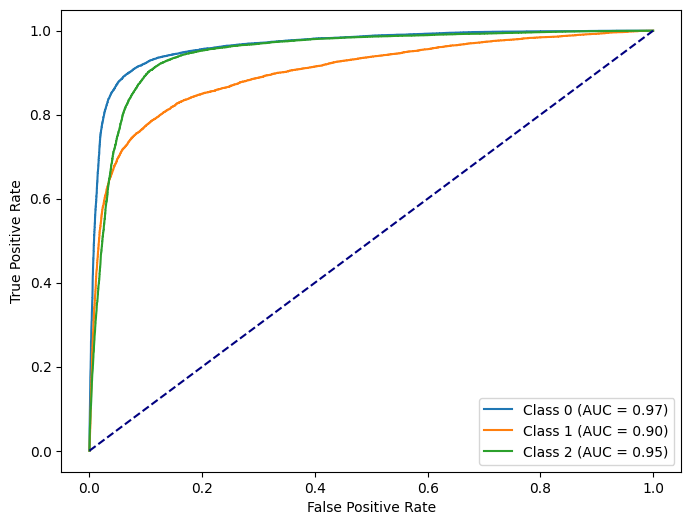

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the true labels (y_test) for each class
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = 3
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class and the diagonal line
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line representing random guessing
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [ ]:
y_pred=np.argmax(y_pred,axis=1)

## Generate the classification report

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.86      0.88     16099
           1       0.73      0.75      0.74     11697
           2       0.89      0.90      0.89     25970

    accuracy                           0.86     53766
   macro avg       0.84      0.84      0.84     53766
weighted avg       0.86      0.86      0.86     53766



## Generating confusion matrix

In [ ]:
cm=confusion_matrix(y_test,y_pred)
print(cm)

[[13849  1346   904]
 [  952  8725  2020]
 [  704  1869 23397]]


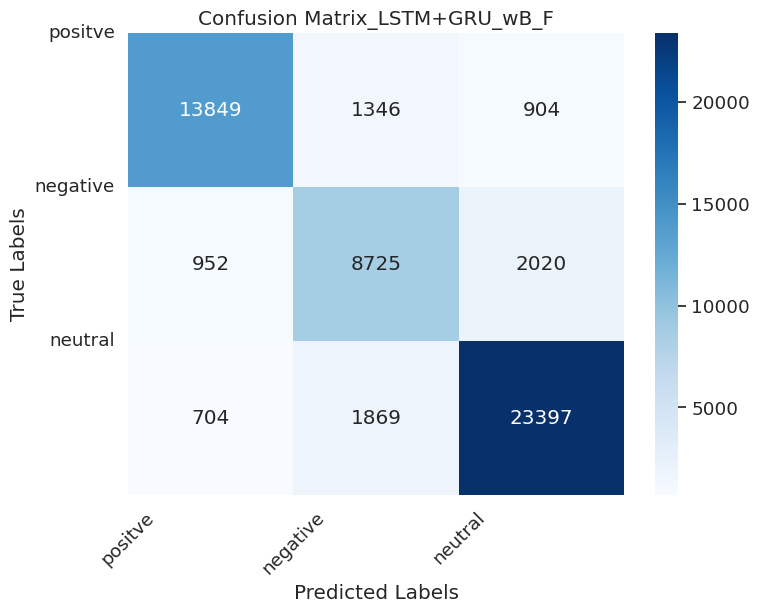

In [ ]:
class_names=['positve','negative','neutral']

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font scale for better readability
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

# Customize labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix_LSTM+GRU_wB_F')
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.yticks(ticks=range(len(class_names)), labels=class_names, rotation=0)

plt.show()

### LSTM with balancing and FAsttext

In [ ]:
pip install imblearn

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [ ]:
x=data.drop(['sentiment'],axis=1)
y=data.sentiment

### distribution before balancing

In [ ]:
print("Distribution of sentiemnt column categories before Balancing\n",Counter(y))

Distribution of sentiemnt column categories before Balancing
 Counter({2: 104713, 0: 64295, 1: 46055})


In [ ]:
sampler =RandomOverSampler(sampling_strategy='auto',random_state=42)

X_resampled, y_resampled = sampler.fit_resample(x, y)

In [ ]:
print("Distribution of sentiemnt column categories After Balancing\n",Counter(y_resampled))

Distribution of sentiemnt column categories After Balancing
 Counter({2: 104713, 1: 104713, 0: 104713})


In [ ]:
data=pd.DataFrame({
    'review':X_resampled.review,
    'sentiment':y_resampled
})

In [ ]:
data.head()

,review,sentiment
0,side effect take combination bystolic milligra...,2
1,son halfway fourth week intuniv become concern...,1
2,use take another oral contraceptive pill cycle...,0
3,first time use form birth control glad go patc...,1
4,suboxone completely turn life around feel heal...,2


In [ ]:
data.shape

(314139, 2)

<Axes: xlabel='sentiment', ylabel='count'>

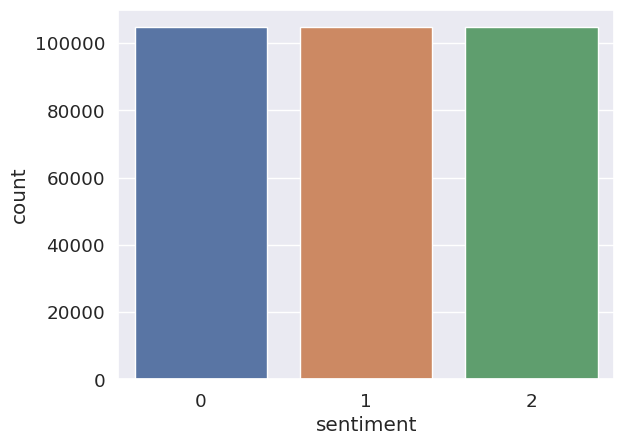

In [ ]:
sns.countplot(x=data.sentiment,data=data)

In [ ]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(data.review)

In [ ]:
vocabulary_size=len(tokenizer.word_index)+1
vocabulary_size

42811

In [ ]:
seq=tokenizer.texts_to_sequences(data.review)

In [ ]:
max_tokens=85

## Padding in order to make size fixed of reivews

In [ ]:
pad_seq=pad_sequences(seq,maxlen=max_tokens,padding='post')

In [ ]:
pad_seq

array([[  12,   11,    1, ...,    0,    0,    0],
       [ 460, 2554, 1216, ...,    0,    0,    0],
       [  23,    1,  155, ...,    0,    0,    0],
       ...,
       [  28,  122,  163, ...,    0,    0,    0],
       [ 419,   16,    4, ...,    0,    0,    0],
       [   8,   32,  874, ...,    0,    0,    0]], dtype=int32)

In [ ]:
len(data.sentiment)

314139

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(pad_seq,data.sentiment,test_size=0.25,random_state=42)

### Fasttext embedding

In [ ]:
embedding_matrix=np.zeros((vocabulary_size,100))
for word,i in tokenizer.word_index.items():
  if word in modelf.wv:
    embedding_matrix[i]=modelf.wv[word]

In [ ]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.2425763 , -0.0936817 , -0.05199119, ..., -0.03677011,
        -0.00818118, -0.04921057],
       [ 0.21328464,  0.12883675, -0.23028792, ..., -0.21601029,
        -0.02633418,  0.17376316],
       ...,
       [-0.01923225,  0.22732052, -0.013306  , ..., -0.31475088,
         0.06977516,  0.32320186],
       [ 0.12901592, -0.18751198, -0.11990177, ..., -0.20984215,
         0.16321383,  0.21282101],
       [-0.09692582,  0.12687205, -0.16241328, ..., -0.37290141,
        -0.25893915,  0.1915738 ]])

In [ ]:
modelf.wv['control']

array([-0.0964525 , -0.2365019 , -0.545835  ,  0.04864793,  0.09930725,
       -0.27573067,  0.4457071 ,  0.3023038 , -0.01951359, -0.7292269 ,
       -0.115165  ,  0.38081527, -0.07105099, -0.09628899,  0.33547917,
       -0.49469283,  0.12613413,  0.1227507 , -0.29121923,  0.15625115,
        0.09942341,  0.0300792 , -0.1004178 , -0.33156922, -0.11944138,
       -0.27105978, -0.27293056,  0.05900936,  0.03510495, -0.29889548,
        0.39233074,  0.4054492 ,  0.47125256, -0.0548275 , -0.20021787,
        0.49714065, -0.44883868,  0.12539637, -0.3960319 ,  0.10827566,
        0.40707046,  0.2572192 ,  0.11848535, -0.18445075, -0.12547924,
       -0.03609515, -0.10178619,  0.2232027 ,  0.3452304 ,  0.04326997,
        0.3285916 , -0.35362738, -0.09814943,  0.27744466, -0.22133775,
        0.08514971, -0.09099489,  0.38867062,  0.17501189,  0.17744488,
       -0.2832153 ,  0.05684539, -0.09345663,  0.3152441 ,  0.6095747 ,
        0.14440517,  0.01370558,  0.12604915,  0.21087502,  0.24

## LSTM model with Balanced Dataset

In [ ]:
model2=Sequential()
model2.add(Embedding(input_dim=vocabulary_size,output_dim=100,input_length=max_tokens,weights=[embedding_matrix],trainable=False))
model2.add(SpatialDropout1D(0.1))
model2.add(LSTM(units=200,activation='tanh'))
#output layer
model2.add(Dense(3,activation='softmax'))
optimizer=Adam(lr=1e-3)
model2.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 85, 100)           4281100   
                                                                 
 spatial_dropout1d_5 (Spati  (None, 85, 100)           0         
 alDropout1D)                                                    
                                                                 
 lstm_7 (LSTM)               (None, 200)               240800    
                                                                 
 dense_7 (Dense)             (None, 3)                 603       
                                                                 
Total params: 4522503 (17.25 MB)
Trainable params: 241403 (942.98 KB)
Non-trainable params: 4281100 (16.33 MB)
_________________________________________________________________


In [ ]:
history=model2.fit(x_train,y_train,epochs=60,verbose=1,validation_data=(x_test,y_test),batch_size=200)

Epoch 1/60
1179/1179 [==============================] - 25s 19ms/step - loss: 0.9361 - accuracy: 0.5355 - val_loss: 1.0261 - val_accuracy: 0.5437
Epoch 2/60
1179/1179 [==============================] - 20s 17ms/step - loss: 0.8527 - accuracy: 0.5994 - val_loss: 0.8112 - val_accuracy: 0.6189
Epoch 3/60
1179/1179 [==============================] - 20s 17ms/step - loss: 0.8075 - accuracy: 0.6267 - val_loss: 0.7852 - val_accuracy: 0.6395
Epoch 4/60
1179/1179 [==============================] - 20s 17ms/step - loss: 0.7713 - accuracy: 0.6459 - val_loss: 0.7784 - val_accuracy: 0.6380
Epoch 5/60
1179/1179 [==============================] - 20s 17ms/step - loss: 0.7423 - accuracy: 0.6614 - val_loss: 0.7305 - val_accuracy: 0.6681
Epoch 6/60
1179/1179 [==============================] - 20s 17ms/step - loss: 0.7118 - accuracy: 0.6787 - val_loss: 0.7224 - val_accuracy: 0.6775
Epoch 7/60
1179/1179 [==============================] - 20s 17ms/step - loss: 0.6841 - accuracy: 0.6950 - val_loss: 0.6823 -

## Results

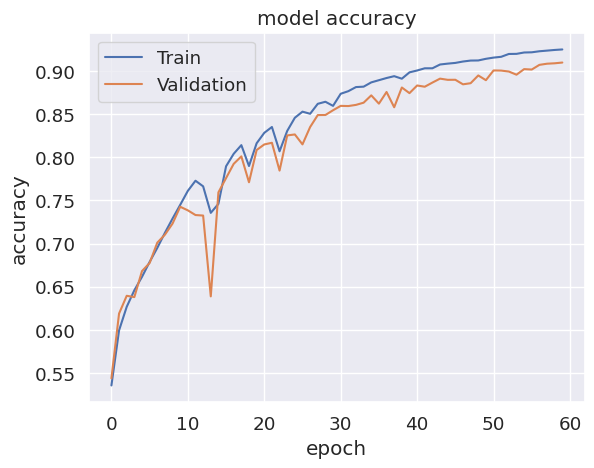

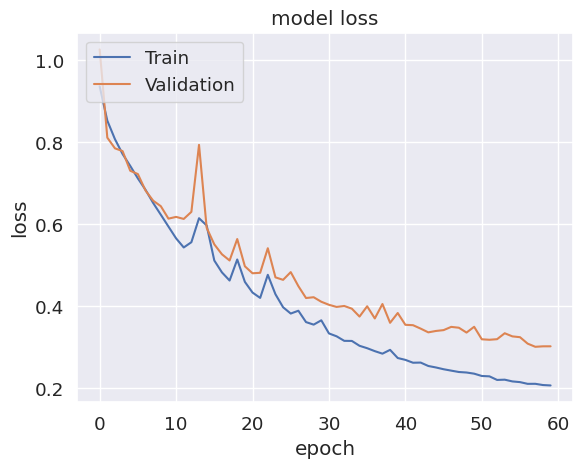

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
loss,accuracy=model2.evaluate(x_test,y_test)
print(f"Accuracy:{accuracy}\n Loss:{loss}")

2455/2455 [==============================] - 10s 4ms/step - loss: 0.3027 - accuracy: 0.9099
Accuracy:0.9099255204200745
 Loss:0.3027145266532898


In [ ]:
y_pred=model2.predict(x_test)

2455/2455 [==============================] - 9s 3ms/step


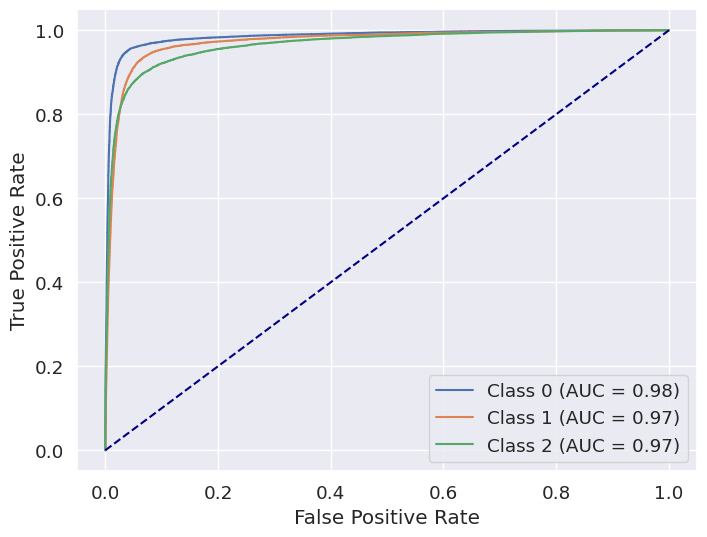

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the true labels (y_test) for each class
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = 3
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class and the diagonal line
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line representing random guessing
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [ ]:
y_pred=np.argmax(y_pred,axis=1)

In [ ]:
# Generate the classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     26246
           1       0.88      0.93      0.90     26077
           2       0.91      0.86      0.89     26212

    accuracy                           0.91     78535
   macro avg       0.91      0.91      0.91     78535
weighted avg       0.91      0.91      0.91     78535



In [ ]:
#confusion matrix
cm=confusion_matrix(y_test,y_pred)
print(cm)

[[24683   683   880]
 [  550 24225  1302]
 [ 1078  2581 22553]]


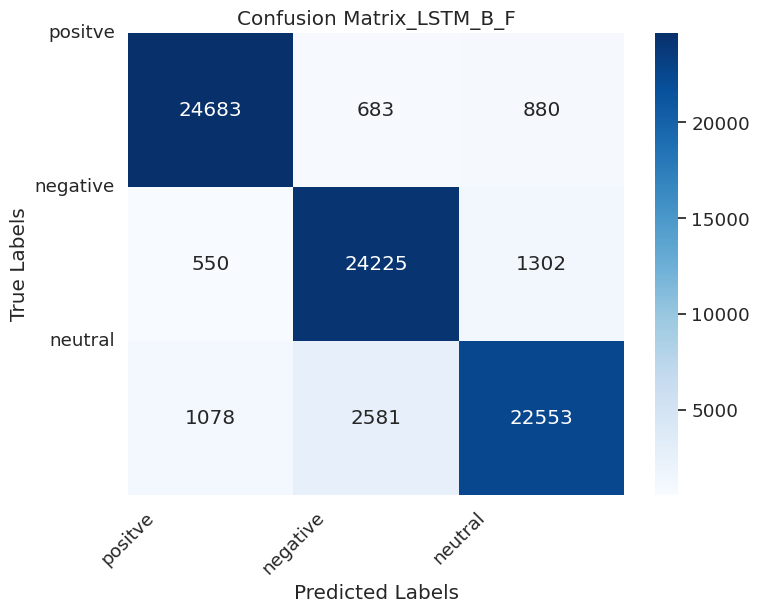

In [ ]:
class_names=['positve','negative','neutral']

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font scale for better readability
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

# Customize labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix_LSTM_B_F')
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.yticks(ticks=range(len(class_names)), labels=class_names, rotation=0)

plt.show()

## Bidirectional LSTM with FASTTEXt and balanced dataset

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(pad_seq,data.sentiment,test_size=0.25,random_state=42)

In [ ]:
model4=Sequential()
model4.add(Embedding(input_dim=vocabulary_size,output_dim=100,input_length=max_tokens,weights=[embedding_matrix],trainable=False))
model4.add(SpatialDropout1D(0.1))
model4.add(Bidirectional(LSTM(units=200,activation='tanh')))
#output layer
model4.add(Dense(3,activation='softmax'))
optimizer=Adam(lr=1e-3)
model4.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model4.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 85, 100)           4281100   
                                                                 
 spatial_dropout1d_8 (Spati  (None, 85, 100)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_2 (Bidirecti  (None, 400)               481600    
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 3)                 1203      
                                                                 
Total params: 4763903 (18.17 MB)
Trainable params: 482803 (1.84 MB)
Non-trainable params: 4281100 (16.33 MB)
_________________________________________________________________


In [ ]:
history=model4.fit(x_train,y_train,epochs=60,verbose=1,validation_data=(x_test,y_test),batch_size=200)

Epoch 1/60
1179/1179 [==============================] - 42s 32ms/step - loss: 0.9029 - accuracy: 0.5665 - val_loss: 0.8216 - val_accuracy: 0.6160
Epoch 2/60
1179/1179 [==============================] - 37s 32ms/step - loss: 0.8157 - accuracy: 0.6182 - val_loss: 0.8046 - val_accuracy: 0.6246
Epoch 3/60
1179/1179 [==============================] - 37s 31ms/step - loss: 0.7726 - accuracy: 0.6437 - val_loss: 0.7415 - val_accuracy: 0.6603
Epoch 4/60
1179/1179 [==============================] - 38s 32ms/step - loss: 0.7318 - accuracy: 0.6670 - val_loss: 0.7243 - val_accuracy: 0.6741
Epoch 5/60
1179/1179 [==============================] - 38s 32ms/step - loss: 0.6875 - accuracy: 0.6922 - val_loss: 0.6912 - val_accuracy: 0.6937
Epoch 6/60
1179/1179 [==============================] - 38s 32ms/step - loss: 0.6396 - accuracy: 0.7193 - val_loss: 0.6511 - val_accuracy: 0.7167
Epoch 7/60
1179/1179 [==============================] - 37s 31ms/step - loss: 0.5867 - accuracy: 0.7489 - val_loss: 0.5925 -

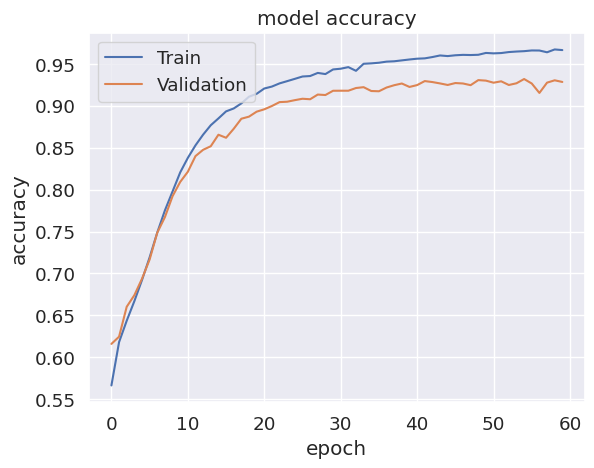

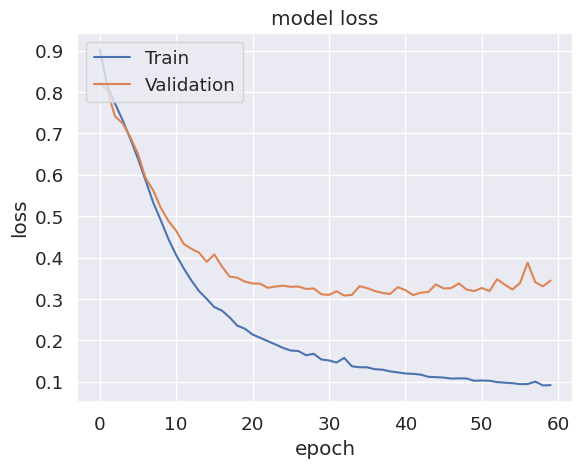

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
loss,accuracy=model4.evaluate(x_test,y_test)
print(f"Accuracy:{accuracy}\n Loss:{loss}")

2455/2455 [==============================] - 15s 6ms/step - loss: 0.3442 - accuracy: 0.9284
Accuracy:0.9283758997917175
 Loss:0.3442256450653076


In [ ]:
y_pred=model4.predict(x_test)

2455/2455 [==============================] - 13s 5ms/step


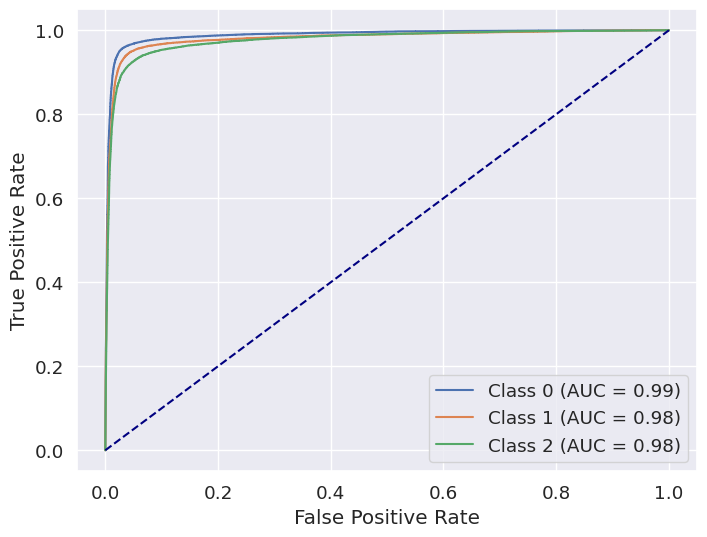

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the true labels (y_test) for each class
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = 3
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class and the diagonal line
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line representing random guessing
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [ ]:
y_pred=np.argmax(y_pred,axis=1)

In [ ]:
# Generate the classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     26246
           1       0.90      0.95      0.92     26077
           2       0.95      0.88      0.91     26212

    accuracy                           0.93     78535
   macro avg       0.93      0.93      0.93     78535
weighted avg       0.93      0.93      0.93     78535



In [ ]:
#confusion matrix
cm=confusion_matrix(y_test,y_pred)
print(cm)

[[25062   659   525]
 [  454 24902   721]
 [ 1044  2222 22946]]


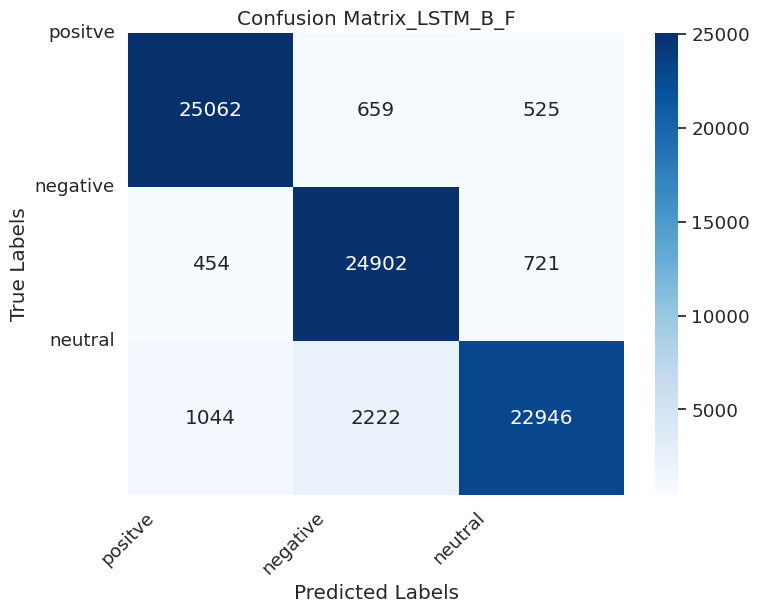

In [ ]:
class_names=['positve','negative','neutral']

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font scale for better readability
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

# Customize labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix_Bi-LSTM_B_F')
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.yticks(ticks=range(len(class_names)), labels=class_names, rotation=0)

plt.show()

## LSTM+GRU Balanced dataset

In [ ]:
modell1=Sequential()
modell1.add(Embedding(input_dim=vocabulary_size,output_dim=100,input_length=max_tokens,weights=[embedding_matrix],trainable=False))
modell1.add(SpatialDropout1D(0.1))
modell1.add(LSTM(units=200,activation='tanh',return_sequences=True))
modell1.add(GRU(units=200,activation='tanh'))
modell1.add(Dense(3,activation='softmax'))
optimizer=Adam(lr=1e-3)
modell1.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
modell1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 85, 100)           4281100   
                                                                 
 spatial_dropout1d_3 (Spati  (None, 85, 100)           0         
 alDropout1D)                                                    
                                                                 
 lstm_3 (LSTM)               (None, 85, 200)           240800    
                                                                 
 gru_3 (GRU)                 (None, 200)               241200    
                                                                 
 dense_3 (Dense)             (None, 3)                 603       
                                                                 
Total params: 4763703 (18.17 MB)
Trainable params: 482603 (1.84 MB)
Non-trainable params: 4281100 (16.33 MB)
___________

In [ ]:
history=modell1.fit(x_train,y_train,epochs=60,verbose=1,validation_data=(x_test,y_test),batch_size=200)

Epoch 1/60
1179/1179 [==============================] - 45s 34ms/step - loss: 0.9183 - accuracy: 0.5499 - val_loss: 0.8209 - val_accuracy: 0.6157
Epoch 2/60
1179/1179 [==============================] - 42s 35ms/step - loss: 0.8175 - accuracy: 0.6181 - val_loss: 0.7837 - val_accuracy: 0.6380
Epoch 3/60
1179/1179 [==============================] - 40s 34ms/step - loss: 0.7722 - accuracy: 0.6425 - val_loss: 0.7449 - val_accuracy: 0.6578
Epoch 4/60
1179/1179 [==============================] - 41s 35ms/step - loss: 0.7377 - accuracy: 0.6629 - val_loss: 0.7225 - val_accuracy: 0.6707
Epoch 5/60
1179/1179 [==============================] - 43s 37ms/step - loss: 0.7003 - accuracy: 0.6841 - val_loss: 0.6871 - val_accuracy: 0.6922
Epoch 6/60
1179/1179 [==============================] - 39s 33ms/step - loss: 0.6561 - accuracy: 0.7090 - val_loss: 0.6556 - val_accuracy: 0.7099
Epoch 7/60
1179/1179 [==============================] - 39s 33ms/step - loss: 0.6060 - accuracy: 0.7360 - val_loss: 0.6238 -

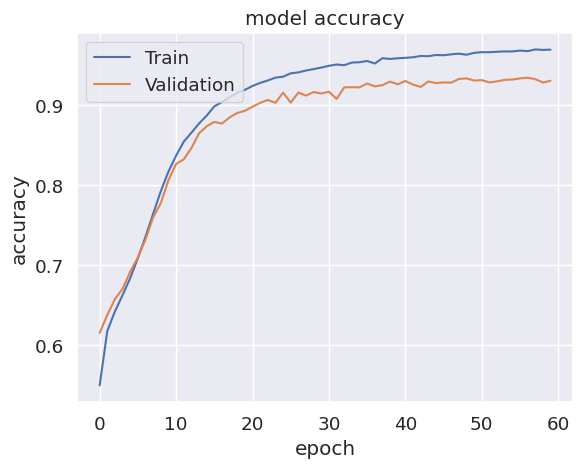

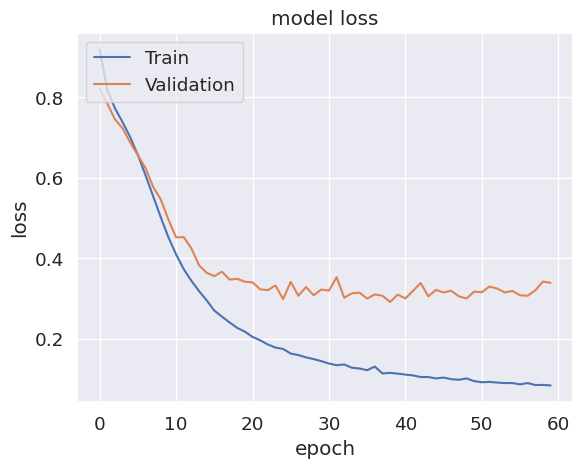

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
loss,accuracy=modell1.evaluate(x_test,y_test)
print(f"Accuracy:{accuracy}\n Loss:{loss}")

2455/2455 [==============================] - 16s 6ms/step - loss: 0.3388 - accuracy: 0.9307
Accuracy:0.9306551218032837
 Loss:0.338846892118454


In [ ]:
y_pred=modell1.predict(x_test)

2455/2455 [==============================] - 12s 5ms/step


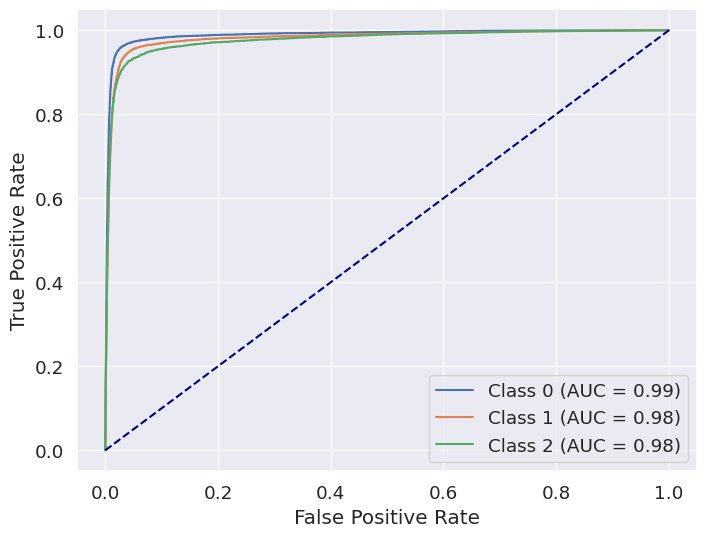

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the true labels (y_test) for each class
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = 3
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class and the diagonal line
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line representing random guessing
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [ ]:
y_pred=np.argmax(y_pred,axis=1)

In [ ]:
# Generate the classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     26246
           1       0.90      0.96      0.93     26077
           2       0.96      0.87      0.91     26212

    accuracy                           0.93     78535
   macro avg       0.93      0.93      0.93     78535
weighted avg       0.93      0.93      0.93     78535



In [ ]:
#confusion matrix
cm=confusion_matrix(y_test,y_pred)
print(cm)

[[25218   609   419]
 [  461 24961   655]
 [ 1090  2212 22910]]


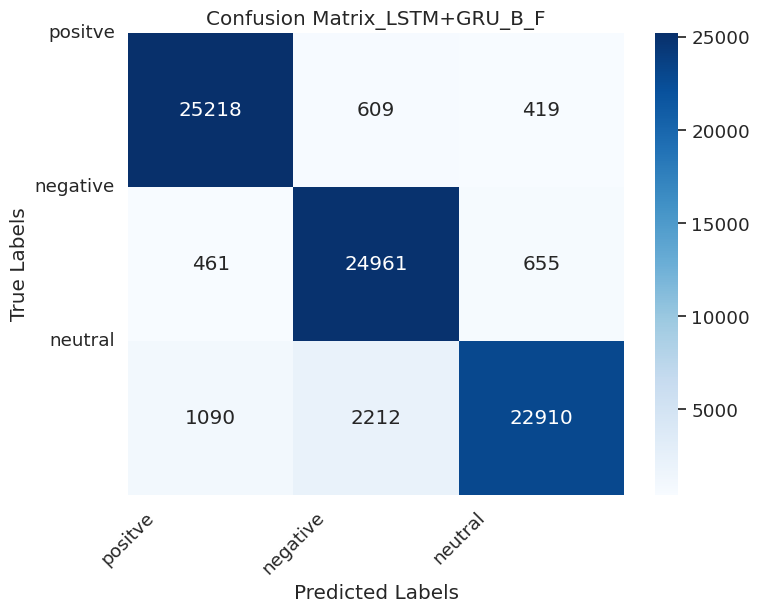

In [ ]:
class_names=['positve','negative','neutral']

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font scale for better readability
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

# Customize labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix_LSTM+GRU_B_F')
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.yticks(ticks=range(len(class_names)), labels=class_names, rotation=0)

plt.show()